# North Carolina Litigation Predictor
# Final Preprocessing and Modeling<br><br>
# ADDRESS CLASS IMBALANCE - MIGHT BE CAUSE OF SHITTY AUC


### Contents:
<ul>
    <li> Import Libraries
    <li> Final Preprocessing / One-Hot Encoding
    <li> Model Creation
        


## Import Libraries & Data

In [60]:
import io
import pandas as pd
import pickle

from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [61]:
# Open the dataframe
infile = open('ProjectData/df_features.data', 'rb')
df = pickle.load(infile)
infile.close()

### Review and Clean DataFrame of Unneeded Columns

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 9 columns):
Opinion                 2666 non-null object
SCT                     2666 non-null int64
Year_Filed              2666 non-null int64
File_Numbers            2666 non-null object
Result                  2666 non-null int64
Case_Type               2666 non-null object
Case_Type_Confidence    2666 non-null object
Trial_Judge             2666 non-null object
County                  2666 non-null object
dtypes: int64(3), object(6)
memory usage: 187.6+ KB


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 9 columns):
Opinion                 2666 non-null object
SCT                     2666 non-null int64
Year_Filed              2666 non-null int64
File_Numbers            2666 non-null object
Result                  2666 non-null int64
Case_Type               2666 non-null object
Case_Type_Confidence    2666 non-null object
Trial_Judge             2666 non-null object
County                  2666 non-null object
dtypes: int64(3), object(6)
memory usage: 187.6+ KB


In [64]:
df.drop(['Opinion', 'SCT', 'File_Numbers', 'Case_Type_Confidence'], axis=1, inplace=True)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 5 columns):
Year_Filed     2666 non-null int64
Result         2666 non-null int64
Case_Type      2666 non-null object
Trial_Judge    2666 non-null object
County         2666 non-null object
dtypes: int64(2), object(3)
memory usage: 104.3+ KB


In [66]:
df.isna().any()

Year_Filed     False
Result         False
Case_Type      False
Trial_Judge    False
County         False
dtype: bool

In [67]:
df.shape

(2666, 5)

### One-Hot Encoding and Train/Test Split

In [68]:
y = df.Result
X = df.drop(columns = ['Result'])

In [96]:
# Either/Or of the following two:
X_gd = pd.get_dummies(X)
ohe = OneHotEncoder(handle_unknown='ignore')
X_ohe = ohe.fit_transform(X)

In [104]:
ohe.get_feature_names(X.columns)
# X.columns

array(['Year_Filed_1998', 'Year_Filed_1999', 'Year_Filed_2000',
       'Year_Filed_2001', 'Year_Filed_2002', 'Year_Filed_2003',
       'Year_Filed_2004', 'Year_Filed_2005', 'Year_Filed_2006',
       'Year_Filed_2007', 'Year_Filed_2008', 'Year_Filed_2009',
       'Year_Filed_2010', 'Year_Filed_2011', 'Year_Filed_2012',
       'Year_Filed_2013', 'Year_Filed_2014', 'Year_Filed_2015',
       'Year_Filed_2016', 'Year_Filed_2017', 'Year_Filed_2018',
       'Year_Filed_2019', 'Year_Filed_2020', 'Case_Type_car_crash',
       'Case_Type_construction', 'Case_Type_contract',
       'Case_Type_corporate', 'Case_Type_defamation',
       'Case_Type_employment', 'Case_Type_estates',
       'Case_Type_family_law', 'Case_Type_fraud_udtpa',
       'Case_Type_governmental', 'Case_Type_insurance',
       'Case_Type_landlord_tenant', 'Case_Type_med_mal',
       'Case_Type_other', 'Case_Type_premises', 'Case_Type_products',
       'Case_Type_property', 'Case_Type_workers_comp',
       'Case_Type_wrongful_de

In [74]:
X_gd.shape, X_ohe.shape

((2666, 595), (2666, 617))

In [77]:
# View class imbalance
y.value_counts()

1    1984
0     682
Name: Result, dtype: int64

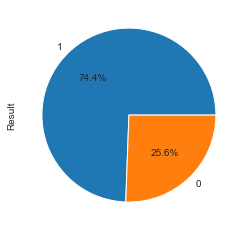

In [78]:
#Visualize class imbalance
y.value_counts().plot.pie(autopct="%.1f%%")

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe,y,random_state = 42, test_size = 0.3)

In [86]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
X_train ,y_train = sm.fit_resample(X_train, y_train) 

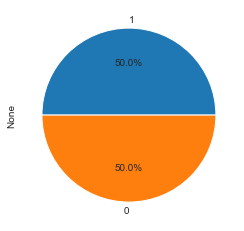

In [87]:
pd.Series(y_train).value_counts().plot.pie(autopct="%.1f%%");

## Modeling

Some research into the best probabilistic classification models suggests that logistic regression, SVMs, and neural networks would be the best fit for the intended goal.  I will run each on the data and see which performs best. 

### Logistic Regression Model

In [88]:
def auc_chart(fpr,tpr):
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    # Plot the ROC curve
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [89]:
def logreg_fn(X_train, X_test, y_train, y_test, params):
    logreg_clf = LogisticRegression(random_state=12)
    logreg_gs = GridSearchCV(logreg_clf, params, cv=5)
    logreg_gs.fit(X_train, y_train)
    best = logreg_gs.best_params_
    
    logreg_final = LogisticRegression(solver=best['solver'],
                                      penalty=best['penalty'],
                                      C=best['C'], 
                                      random_state=12)
    
    logreg_final.fit(X_train, y_train)
    y_hat = logreg_final.predict(X_test)
    y_score = logreg_final.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    AUC = auc(fpr, tpr)

    print('Best params:',best,
          '\n Accuracy Score - Test: ', accuracy_score(y_test, y_hat),
          '\n Confusion Matrix:\n', confusion_matrix(y_test, y_hat), 
          '\n AUC: ', AUC)
    
    auc_chart(fpr,tpr)
    
    return()
    

Best params: {'C': 100, 'penalty': 'none', 'solver': 'lbfgs'} 
 Accuracy Score - Test:  0.56125 
 Confusion Matrix:
 [[ 59 140]
 [211 390]] 
 AUC:  0.4613667338355672


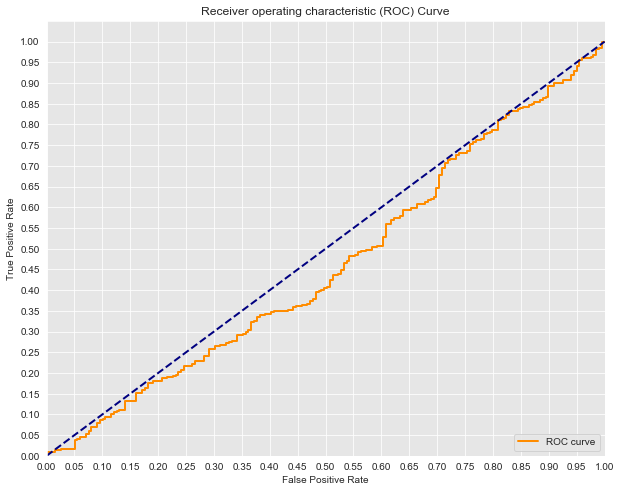

()

In [90]:
parameters = {'C':[100,10,1,.1,.01], 
              'penalty':['l1', 'l2', 'elasticnet', 'none'],
              'solver':['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}

logreg_fn(X_train, X_test, y_train, y_test, parameters)

AUC is NOT GOOD!  The plot is nearly clinging to the 50% line.  
Accuracy is decent, but per the AUC, it's because the model is predicting almost everything as "reversed." 

AttributeError: get_params not found

### SVM Model

### Neural Network

# create tagging and feature set 
# create models 
# create pipeline
# create dashboard


There are many great paid proxy providers like Smartproxy, Netnut, Highproxies, etc. that can be used when scraping and at least you will know that you will get high-quality services that are safe to use with lots of features and big pools of IPs that you can use.